# **Clustering - Módulo 5, Notebook 3/3**

---

## Índice

1. [Introdução](#introducao)
2. [O Problema de Clustering](#problema-clustering)
3. [Datasets de Exemplo](#datasets-exemplo)
4. [K-Means](#kmeans)
   - [Definição e Intuição](#kmeans-intuicao)
   - [Formulação Matemática](#kmeans-matematica)
   - [Implementação com Scikit-Learn](#kmeans-implementacao)
   - [Escolha do Número de Clusters](#kmeans-k)
   - [Análise de Clusters](#kmeans-analise)
5. [DBSCAN](#dbscan)
   - [Definição e Intuição](#dbscan-intuicao)
   - [Formulação Matemática](#dbscan-matematica)
   - [Implementação com Scikit-Learn](#dbscan-implementacao)
   - [Escolha de Hiperparâmetros](#dbscan-hiperparametros)
   - [Análise de Clusters](#dbscan-analise)
   - [Comparação K-Means vs DBSCAN](#kmeans-dbscan-comparacao)
6. [Gaussian Mixture Models (GMM)](#gmm)
   - [Definição e Intuição](#gmm-intuicao)
   - [Formulação Matemática](#gmm-matematica)
   - [Implementação com Scikit-Learn](#gmm-implementacao)
   - [Análise de Clusters e Critérios de Informação](#gmm-analise)
   - [Comparação com K-Means e DBSCAN](#gmm-comparacao)
7. [Outros Métodos de Clustering](#outros-metodos)
8. [Conclusão](#conclusao)

---

<a id='introducao'></a>
## 1. Introdução

Clustering é a tarefa mais útil em aprendizado não-supervisionado que busca agrupar dados em conjuntos internamente coerentes, sem conhecer as categorias corretas de antemão. Diferentemente de classificação, onde temos rótulos verdadeiros, em clustering descobrimos a estrutura dos dados puramente pelos padrões de proximidade e densidade.

Neste notebook exploraremos os três métodos mais importantes:
- **K-Means**
- **DBSCAN**
- **Gaussian Mixture Models (GMM)**

Cada método tem força e fraqueza. Aqui aprenderemos quando aplicar cada um, como ajustar hiperparâmetros e como avaliar a qualidade dos clusters obtidos.

In [2]:
# ======= IMPORTS =======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs, make_moons, make_circles, load_iris
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Configuração visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

<a id='problema-clustering'></a>
## 2. O Problema de Clustering

Clustering responde à pergunta fundamental: **"Quais observações são similares entre si?"** Essa pergunta surge frequentemente em análise de dados: segmentação de clientes, agrupamento de imagens similares, detecção de anomalias, análise de redes sociais, entre muitos outros cenários.

O desafio principal é que "similaridade" pode significar coisas distintas dependendo do contexto:
- **Proximidade euclidiana**: Pontos geometricamente pertos no espaço
- **Densidade**: Regiões com alta concentração de pontos
- **Conectividade**: Pontos ligados através de vizinhos próximos
- **Probabilidade**: Probabilidade de pertencer à mesma distribuição

Diferentes algoritmos de clustering exploram diferentes noções de similaridade, o que explica por que nenhum método é universal - o problema é fundamentalmente dependente de domínio e de conhecimento prévio sobre a estrutura esperada dos dados.

<a id='datasets-exemplo'></a>
## 3. Datasets de Exemplo

Para ilustrar as diferenças entre algoritmos de clustering, trabalharemos com três datasets sintéticos. A variedade de estruturas nos ajuda a construir intuição sobre quando usar qual abordagem.

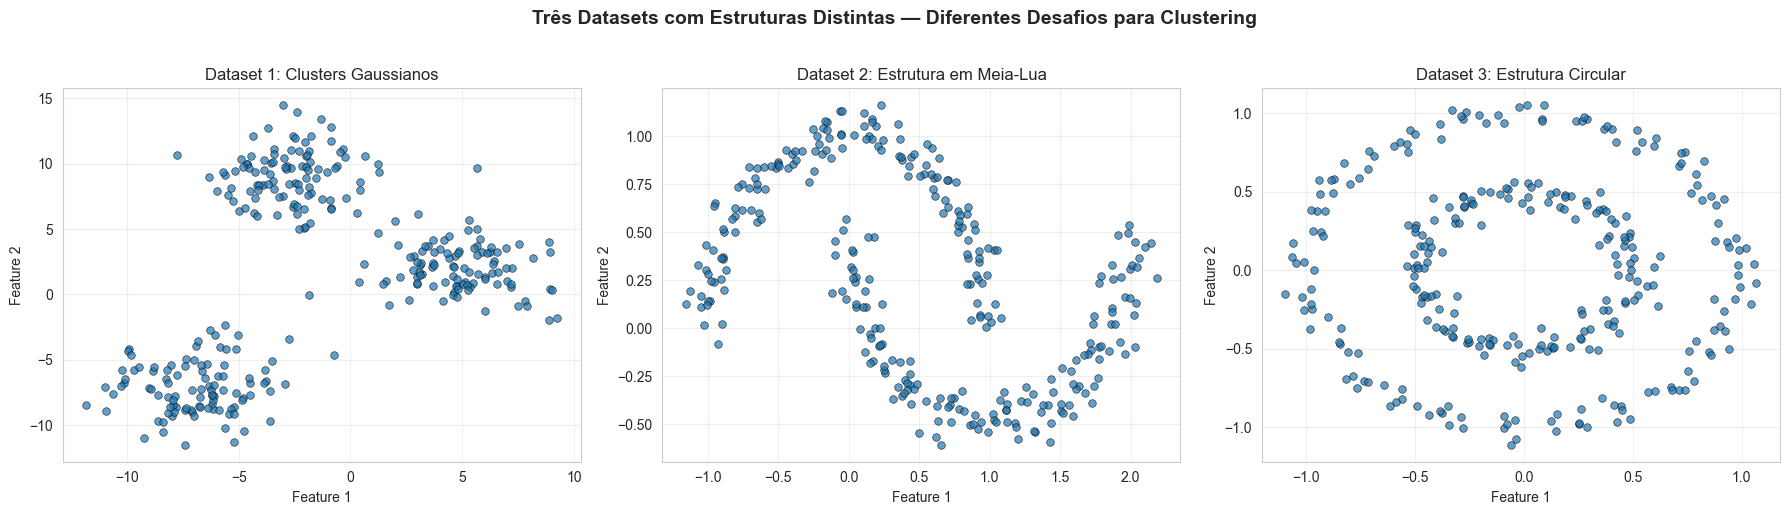

In [14]:
# ======= GERAR DATASETS DE EXEMPLO =======

# Dataset 1: Clusters bem-separados
X_blobs, _ = make_blobs(n_samples=300, centers=3, n_features=2, 
                        cluster_std=2, random_state=42)

# Dataset 2: Estrutura em meia-lua 
X_moons, _ = make_moons(n_samples=300, noise=0.07, random_state=42)

# Dataset 3: Estrutura circular 
X_circles, _ = make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42)

# Normalizar dados
scaler = StandardScaler()
X_blobs_norm = scaler.fit_transform(X_blobs)
X_moons_norm = scaler.fit_transform(X_moons)
X_circles_norm = scaler.fit_transform(X_circles)

# Visualizar os datasets
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_blobs[:, 0], X_blobs[:, 1], s=30, alpha=0.7, edgecolors='k', linewidth=0.5)
axes[0].set_title('Dataset 1: Clusters Gaussianos', fontsize=12)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(X_moons[:, 0], X_moons[:, 1], s=30, alpha=0.7, edgecolors='k', linewidth=0.5)
axes[1].set_title('Dataset 2: Estrutura em Meia-Lua', fontsize=12)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].grid(True, alpha=0.3)

axes[2].scatter(X_circles[:, 0], X_circles[:, 1], s=30, alpha=0.7, edgecolors='k', linewidth=0.5)
axes[2].set_title('Dataset 3: Estrutura Circular', fontsize=12)
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Três Datasets com Estruturas Distintas - Diferentes Desafios para Clustering', 
             fontsize=14, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()


<a id='kmeans'></a>
## 4. K-Means

<a id='kmeans-intuicao'></a>
### 4.1 Definição e Intuição

**K-Means** é o algoritmo de clustering mais simples e mais amplamente utilizado. A ideia é particionador: divida os dados em exatamente $k$ clusters, minimizando a variância intra-cluster (a distância média de cada ponto ao centroide do seu cluster).

A intuição é elegante: imagine que você joga $k$ "sementes" aleatoriamente no espaço dos dados. Cada ponto se associa à semente mais próxima. Depois, você recalcula a posição de cada semente como o centroide (centro de massa) de todos os pontos atribuídos a ela. Repita este processo: atribuição + recálculo de centroides. Eventualmente convergirá para um ponto de equilíbrio.

**Vantagens do K-Means**:
- Muito rápido, escalável para grandes datasets
- Implementação simples
- Funciona bem com dados bem-separados e esféricos
- Produz clusters interpretáveis

**Limitações**:
- Requer conhecimento prévio de $k$ (número de clusters)
- Sensível a inicialização aleatória
- Falha em estruturas não-convexas (como meia-lua)
- Assume clusters de tamanho similar



<a id='kmeans-matematica'></a>
### 4.2 Formulação Matemática

Dado um dataset $\mathbf{X} \in \mathbb{R}^{m \times n}$ e um número de clusters $k$, o objetivo do K-Means é encontrar $k$ centroides $\boldsymbol{\mu}_1, ..., \boldsymbol{\mu}_k$ e atribuições de cluster que minimizem a **inércia total**:

$$J = \sum_{i=1}^{m} \min_{j \in \{1,...,k\}} \|\mathbf{x}_i - \boldsymbol{\mu}_j\|^2$$

O algoritmo procede em duas etapas que se repetem:

**Passo 1 - Atribuição (Expectation)**  
Atribua cada ponto $\mathbf{x}_i$ ao cluster do centroide mais próximo:
$$c_i = \arg\min_{j} \|\mathbf{x}_i - \boldsymbol{\mu}_j\|^2$$

**Passo 2 - Atualização de Centroides (Maximization)**  
Recalcule cada centroide como a média de todos os pontos no cluster:
$$\boldsymbol{\mu}_j = \frac{1}{|C_j|} \sum_{\mathbf{x}_i \in C_j} \mathbf{x}_i$$

onde $C_j$ é o conjunto de pontos no cluster $j$.

Este processo converge garantidamente (a inércia nunca aumenta) em um número finito de iterações, embora o resultado pode ser um ótimo local, não global, dependendo da inicialização.



<a id='kmeans-implementacao'></a>
### 4.3 Implementação com Scikit-Learn


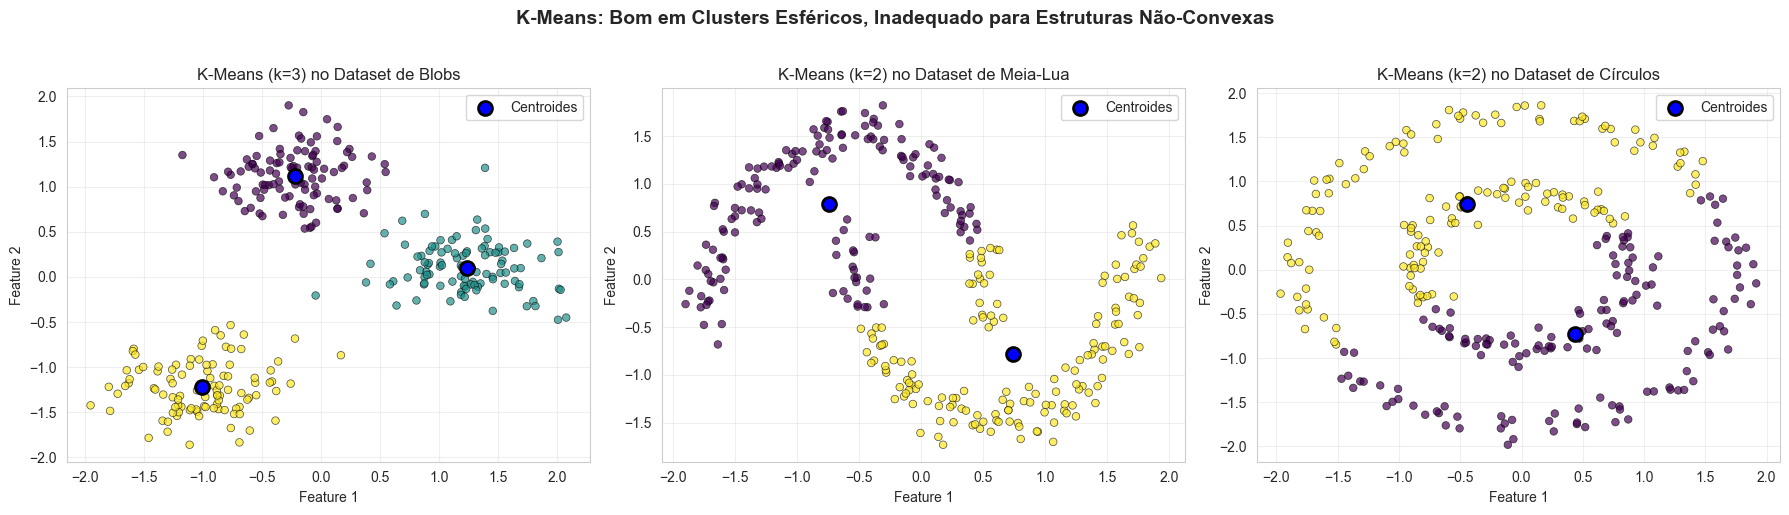

In [22]:
# ======= K-MEANS NO DATASET DE BLOBS =======

# Aplicar K-Means com k=3
kmeans_blobs = KMeans(n_clusters=3, n_init=10, random_state=42)
labels_kmeans_blobs = kmeans_blobs.fit_predict(X_blobs_norm)

# Visualizar resultado
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Dataset 1: Blobs
scatter1 = axes[0].scatter(X_blobs_norm[:, 0], X_blobs_norm[:, 1], 
                           c=labels_kmeans_blobs, cmap='viridis', s=30, alpha=0.7, edgecolors='k', linewidth=0.5)
axes[0].scatter(kmeans_blobs.cluster_centers_[:, 0], kmeans_blobs.cluster_centers_[:, 1], 
               marker='o', s=100, c='b', edgecolors='black', linewidth=2, label='Centroides')
axes[0].set_title('K-Means (k=3) no Dataset de Blobs', fontsize=12)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Dataset 2: Meia-lua
kmeans_moons = KMeans(n_clusters=2, n_init=10, random_state=42)
labels_kmeans_moons = kmeans_moons.fit_predict(X_moons_norm)
scatter2 = axes[1].scatter(X_moons_norm[:, 0], X_moons_norm[:, 1], 
                           c=labels_kmeans_moons, cmap='viridis', s=30, alpha=0.7, edgecolors='k', linewidth=0.5)
axes[1].scatter(kmeans_moons.cluster_centers_[:, 0], kmeans_moons.cluster_centers_[:, 1], 
               marker='o', s=100, c='b', edgecolors='black', linewidth=2, label='Centroides')
axes[1].set_title('K-Means (k=2) no Dataset de Meia-Lua', fontsize=12)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Dataset 3: Círculos
kmeans_circles = KMeans(n_clusters=2, n_init=10, random_state=42)
labels_kmeans_circles = kmeans_circles.fit_predict(X_circles_norm)
scatter3 = axes[2].scatter(X_circles_norm[:, 0], X_circles_norm[:, 1], 
                           c=labels_kmeans_circles, cmap='viridis', s=30, alpha=0.7, edgecolors='k', linewidth=0.5)
axes[2].scatter(kmeans_circles.cluster_centers_[:, 0], kmeans_circles.cluster_centers_[:, 1], 
               marker='o', s=100, c='b', edgecolors='black', linewidth=2, label='Centroides')
axes[2].set_title('K-Means (k=2) no Dataset de Círculos', fontsize=12)
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('K-Means: Bom em Clusters Esféricos, Inadequado para Estruturas Não-Convexas', 
             fontsize=14, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()


<a id='kmeans-k'></a>
### 4.4 Escolha do Número de Clusters

Uma das dificuldades principais de K-Means é que você precisa decidir quantos clusters existem **antes** de executar o algoritmo. Qual o correto? - depende do problema. Mas existem métodos para guiar essa escolha:

#### 4.4.1 Elbow Method

A ideia é simples: rode K-Means para diferentes valores de $k$ (1, 2, 3, ...) e observe como a inércia (soma de distâncias ao centroide) diminui. Frequentemente há um "cotovelo" - um ponto onde a diminuição desacelera bruscamente. Esse é um candidato natural para o número de clusters.


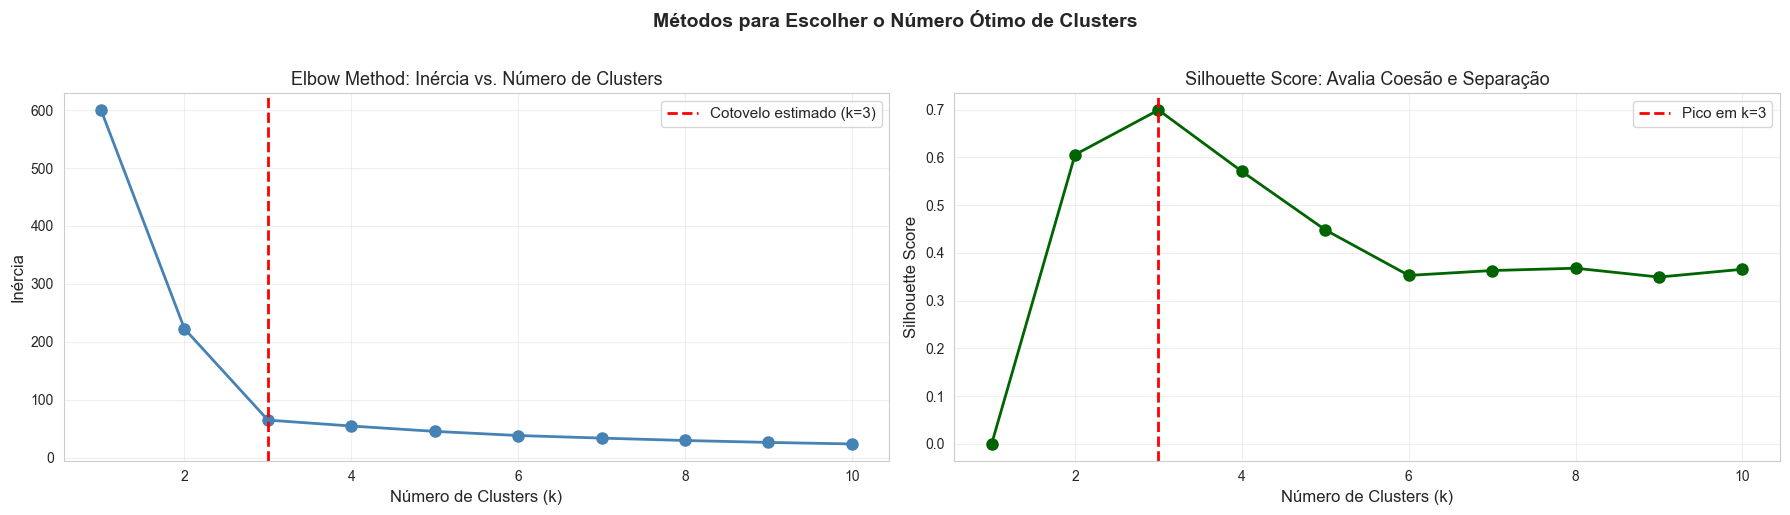

In [26]:
# ======= ELBOW METHOD =======

# Calcular inércia para diferentes valores de k
k_range = range(1, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_blobs_norm)
    inertias.append(kmeans.inertia_)
    
    # Silhouette score (apenas para k > 1)
    if k > 1:
        sil_score = silhouette_score(X_blobs_norm, labels)
        silhouette_scores.append(sil_score)
    else:
        silhouette_scores.append(0)

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Elbow plot
axes[0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].axvline(x=3, color='red', linestyle='--', linewidth=2, label='Cotovelo estimado (k=3)')
axes[0].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inércia', fontsize=12)
axes[0].set_title('Elbow Method: Inércia vs. Número de Clusters', fontsize=13)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Silhouette score
axes[1].plot(k_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='darkgreen')
axes[1].axvline(x=3, color='red', linestyle='--', linewidth=2, label='Pico em k=3')
axes[1].set_xlabel('Número de Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score: Avalia Coesão e Separação', fontsize=13)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Métodos para Escolher o Número Ótimo de Clusters', fontsize=14, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()


<a id='kmeans-analise'></a>
### 4.5 Análise de Clusters

Uma vez que você tem clusters, é essencial avaliar sua qualidade. Métricas comuns incluem:

- **Silhouette Score**: Mede se cada ponto está mais próximo de seu próprio centroide do que de centroides vizinhos. Varia de -1 a +1, com valores próximos a 1 indicando clusters bem-definidos.
- **Davies-Bouldin Index**: Razão entre distâncias intra-cluster e inter-cluster. Valores menores são melhores.
- **Calinski-Harabasz Score**: Razão entre dispersão entre clusters e dentro de clusters. Valores maiores são melhores.

Use-as em combinação para ter visão mais clara.


In [28]:
# ======= AVALIAR QUALIDADE DOS CLUSTERS =======

kmeans_optimal = KMeans(n_clusters=3, n_init=10, random_state=42)
labels_optimal = kmeans_optimal.fit_predict(X_blobs_norm)

# Calcular métricas
sil_score = silhouette_score(X_blobs_norm, labels_optimal)
db_index = davies_bouldin_score(X_blobs_norm, labels_optimal)
ch_score = calinski_harabasz_score(X_blobs_norm, labels_optimal)

print(f"Avaliação dos Clusters (K-Means, k=3):")
print(f"  Silhouette Score: {sil_score:.4f} (range: -1 a 1, maior é melhor)")
print(f"  Davies-Bouldin Index: {db_index:.4f} (menor é melhor)")
print(f"  Calinski-Harabasz Score: {ch_score:.4f} (maior é melhor)")


Avaliação dos Clusters (K-Means, k=3):
  Silhouette Score: 0.6991 (range: -1 a 1, maior é melhor)
  Davies-Bouldin Index: 0.4139 (menor é melhor)
  Calinski-Harabasz Score: 1217.3051 (maior é melhor)



---

<a id='dbscan'></a>
## 5. DBSCAN

<a id='dbscan-intuicao'></a>
### 5.1 Definição e Intuição

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** representa uma mudança fundamental de perspectiva em relação ao K-Means. Ao invés de assumir que clusters são esféricos e de tamanho similar, DBSCAN assume que clusters são **regiões de alta densidade** conectadas através de pontos próximos.

A intuição é simples: um ponto pertence a um cluster se há muitos outros pontos próximos a ele. Mais formalmente, se você desenha um círculo de raio $\epsilon$ ao redor de um ponto e há pelo menos $m$ vizinhos dentro desse círculo, esse ponto e seus vizinhos estão no mesmo cluster. Dois clusters são conectados se pontos de um estão dentro do raio de pontos do outro.

**Vantagens do DBSCAN**:
- Não requer conhecer $k$ de antemão
- Detecta clusters de forma arbitrária (não-convexos)
- Identifica outliers naturalmente (pontos que não pertencem a nenhum cluster)
- Eficaz em estruturas não-lineares

**Limitações**:
- Sensível aos hiperparâmetros $\epsilon$ (raio) e $m$ (mínimo de vizinhos)
- Tem dificuldade com clusters de densidade variável
- Computacionalmente mais custoso em altas dimensões (requer cálculo de distâncias)



<a id='dbscan-matematica'></a>
### 5.2 Formulação Matemática

Como já disse, o algoritmo DBSCAN opera com dois hiperparâmetros principais:

- **$\epsilon$ (eps)**: Raio de vizinhança ao redor de cada ponto
- **MinPts** (min_samples): Número mínimo de pontos dentro de $\epsilon$ para considerá-lo "central"

**Definições**:

Um ponto $\mathbf{x}_i$ é chamado **ponto central** (core point) se sua vizinhança $\mathcal{N}_\epsilon(\mathbf{x}_i) = \{\mathbf{x}_j : d(\mathbf{x}_i, \mathbf{x}_j) \leq \epsilon\}$ contém pelo menos MinPts pontos (incluindo ele próprio).

Um ponto $\mathbf{x}_j$ é **diretamente alcançável** (directly density-reachable) a partir de $\mathbf{x}_i$ se $\mathbf{x}_i$ é um ponto central e $\mathbf{x}_j \in \mathcal{N}_\epsilon(\mathbf{x}_i)$.

Um ponto é **densidade-alcançável** (density-reachable) se existe uma sequência de pontos conectando-o a um ponto central.

**Algoritmo**:

1. Para cada ponto não visitado $\mathbf{x}_i$:
   - Se $\mathbf{x}_i$ é um ponto central, crie um novo cluster e adicione todos os pontos densidade-alcançáveis
   - Caso contrário, marque-o como outlier

Diferentemente do K-Means, DBSCAN produz naturalmente um rótulo especial para outliers (tipicamente -1), oferecendo detecção automática de anomalias.



<a id='dbscan-implementacao'></a>
### 5.3 Implementação com Scikit-Learn


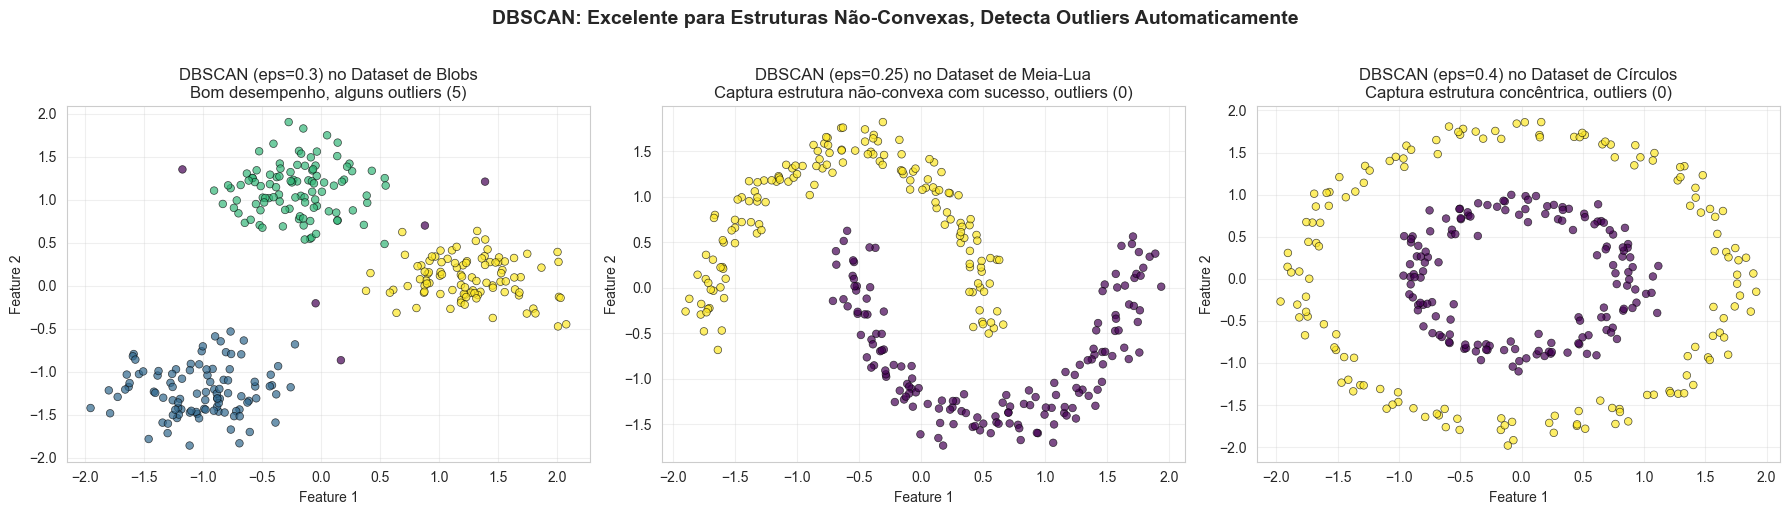

In [56]:
# ======= DBSCAN NOS DATASETS DE EXEMPLO =======

# DBSCAN nos três datasets
dbscan_blobs = DBSCAN(eps=0.3, min_samples=5)
labels_dbscan_blobs = dbscan_blobs.fit_predict(X_blobs_norm)

dbscan_moons = DBSCAN(eps=0.25, min_samples=5)
labels_dbscan_moons = dbscan_moons.fit_predict(X_moons_norm)

dbscan_circles = DBSCAN(eps=0.4, min_samples=5)
labels_dbscan_circles = dbscan_circles.fit_predict(X_circles_norm)

# Visualizar
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Dataset 1: Blobs
scatter1 = axes[0].scatter(X_blobs_norm[:, 0], X_blobs_norm[:, 1], 
                           c=labels_dbscan_blobs, cmap='viridis', s=30, alpha=0.7, 
                           edgecolors='k', linewidth=0.5)

outliers_blobs = labels_dbscan_blobs == -1
axes[0].set_title(f'DBSCAN (eps=0.3) no Dataset de Blobs\nBom desempenho, alguns outliers ({outliers_blobs.sum()})', fontsize=12)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].grid(True, alpha=0.3)

# Dataset 2: Meia-lua
scatter2 = axes[1].scatter(X_moons_norm[:, 0], X_moons_norm[:, 1], 
                           c=labels_dbscan_moons, cmap='viridis', s=30, alpha=0.7, 
                           edgecolors='k', linewidth=0.5)
outliers_moons = labels_dbscan_moons == -1
axes[1].set_title(f'DBSCAN (eps=0.25) no Dataset de Meia-Lua\nCaptura estrutura não-convexa com sucesso, outliers ({outliers_moons.sum()})', fontsize=12)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].grid(True, alpha=0.3)

# Dataset 3: Círculos
scatter3 = axes[2].scatter(X_circles_norm[:, 0], X_circles_norm[:, 1], 
                           c=labels_dbscan_circles, cmap='viridis', s=30, alpha=0.7, 
                           edgecolors='k', linewidth=0.5)
outliers_circles = labels_dbscan_circles == -1
axes[2].set_title(f'DBSCAN (eps=0.4) no Dataset de Círculos\nCaptura estrutura concêntrica, outliers ({outliers_circles.sum()})', fontsize=12)
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')
axes[2].grid(True, alpha=0.3)

plt.suptitle('DBSCAN: Excelente para Estruturas Não-Convexas, Detecta Outliers Automaticamente', 
             fontsize=14, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()


<a id='dbscan-hiperparametros'></a>
### 5.4 Escolha de Hiperparâmetros

A qualidade de DBSCAN depende criticamente de $\epsilon$ (eps) e min_samples. Escolhas ruins levam a sobre-segmentação (clusters demais) ou sub-segmentação (tudo como um cluster).

#### 5.4.1 O Gráfico K-Distance

Uma heurística comum é o **k-distance graph**: para cada ponto, calcule a distância para seu $k$-ésimo vizinho mais próximo (onde $k$ = min_samples). Ordene essas distâncias em ordem decrescente. O gráfico resultante frequentemente apresenta um "joelho" - um ponto onde há grande salto. O valor $\epsilon$ deve estar perto dessa distância de joelho.


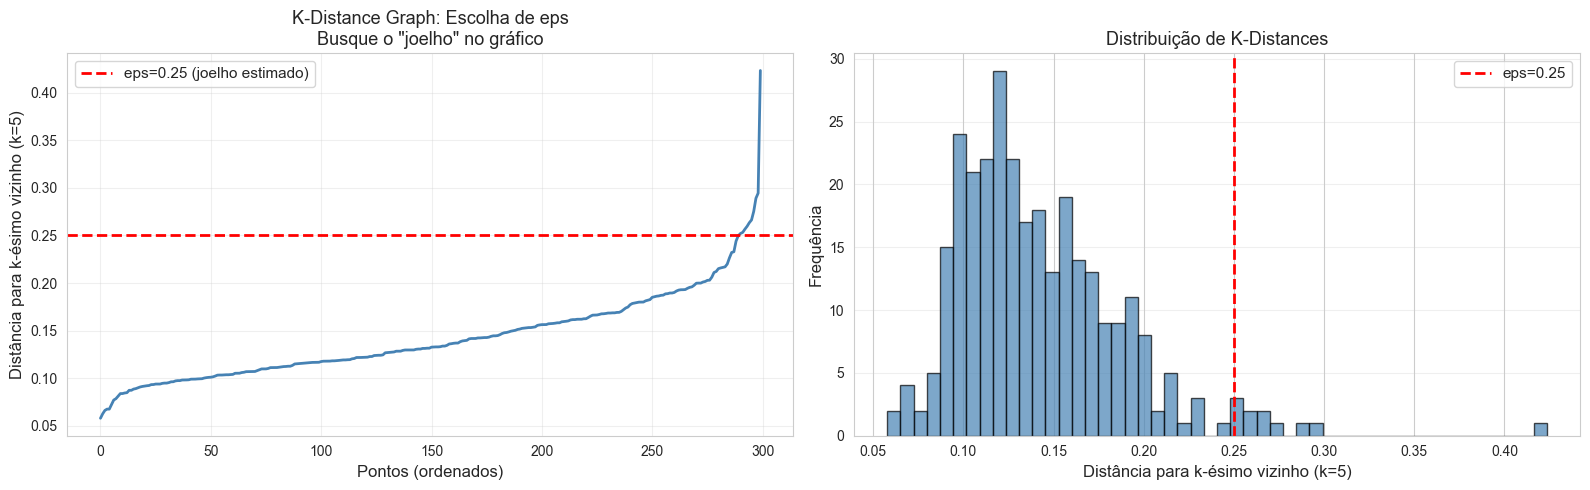

In [58]:
# ======= K-DISTANCE GRAPH =======

from sklearn.neighbors import NearestNeighbors

# Calcular k-distances para dataset de meia-lua
k = 5
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_moons_norm)
distances, indices = neighbors_fit.kneighbors(X_moons_norm)

# Ordenar distâncias (pegar a k-ésima coluna que é a mais distante)
distances = np.sort(distances[:, k-1], axis=0)

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# K-distance plot
axes[0].plot(distances, linewidth=2, color='steelblue')
axes[0].set_xlabel('Pontos (ordenados)', fontsize=12)
axes[0].set_ylabel(f'Distância para k-ésimo vizinho (k={k})', fontsize=12)
axes[0].set_title('K-Distance Graph: Escolha de eps\nBusque o "joelho" no gráfico', fontsize=13)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0.25, color='red', linestyle='--', linewidth=2, label='eps=0.25 (joelho estimado)')
axes[0].legend(fontsize=11)

# Distribuição de distâncias
axes[1].hist(distances, bins=50, edgecolor='black', color='steelblue', alpha=0.7)
axes[1].axvline(x=0.25, color='red', linestyle='--', linewidth=2, label='eps=0.25')
axes[1].set_xlabel(f'Distância para k-ésimo vizinho (k={k})', fontsize=12)
axes[1].set_ylabel('Frequência', fontsize=12)
axes[1].set_title('Distribuição de K-Distances', fontsize=13)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


<a id='dbscan-analise'></a>
### 5.5 Análise de Clusters

Para avaliar DBSCAN, você pode usar métricas como silhouette score, mas é importante lembrar que outliers (rótulo -1) são geralmente excluídos dessas métricas. Também é valioso examinar:
- Número de clusters encontrados
- Número de outliers detectados
- Distribuição de tamanhos de clusters


In [59]:
# ======= ANÁLISE DE CLUSTERS DBSCAN =======

# Aplicar DBSCAN em meia-lua
dbscan_moons = DBSCAN(eps=0.25, min_samples=5)
labels_moons = dbscan_moons.fit_predict(X_moons_norm)

# Calcular métricas (apenas para pontos que não são outliers)
mask_non_outliers = labels_moons != -1
if mask_non_outliers.sum() > 1:
    sil_score_dbscan = silhouette_score(X_moons_norm[mask_non_outliers], labels_moons[mask_non_outliers])
    db_index_dbscan = davies_bouldin_score(X_moons_norm[mask_non_outliers], labels_moons[mask_non_outliers])
    ch_score_dbscan = calinski_harabasz_score(X_moons_norm[mask_non_outliers], labels_moons[mask_non_outliers])
else:
    sil_score_dbscan = db_index_dbscan = ch_score_dbscan = None

n_clusters = len(set(labels_moons)) - (1 if -1 in labels_moons else 0)
n_outliers = list(labels_moons).count(-1)

print(f"Análise de DBSCAN (eps=0.2, min_samples=5) no Dataset de Meia-Lua:")
print(f"  Número de clusters encontrados: {n_clusters}")
print(f"  Número de outliers: {n_outliers}")
if sil_score_dbscan is not None:
    print(f"  Silhouette Score (excluindo outliers): {sil_score_dbscan:.4f}")
    print(f"  Davies-Bouldin Index: {db_index_dbscan:.4f}")
    print(f"  Calinski-Harabasz Score: {ch_score_dbscan:.4f}")

Análise de DBSCAN (eps=0.2, min_samples=5) no Dataset de Meia-Lua:
  Número de clusters encontrados: 2
  Número de outliers: 0
  Silhouette Score (excluindo outliers): 0.3824
  Davies-Bouldin Index: 1.0234
  Calinski-Harabasz Score: 257.0629



<a id='kmeans-dbscan-comparacao'></a>
### 5.6 Comparação: K-Means vs DBSCAN

Uma comparação lado-a-lado revela claramente as forças de cada abordagem. K-Means assume clusters esféricos e conhecimento prévio de $k$. DBSCAN encontra clusters baseado em densidade e não requer $k$, mas é mais sensível a hiperparâmetros.


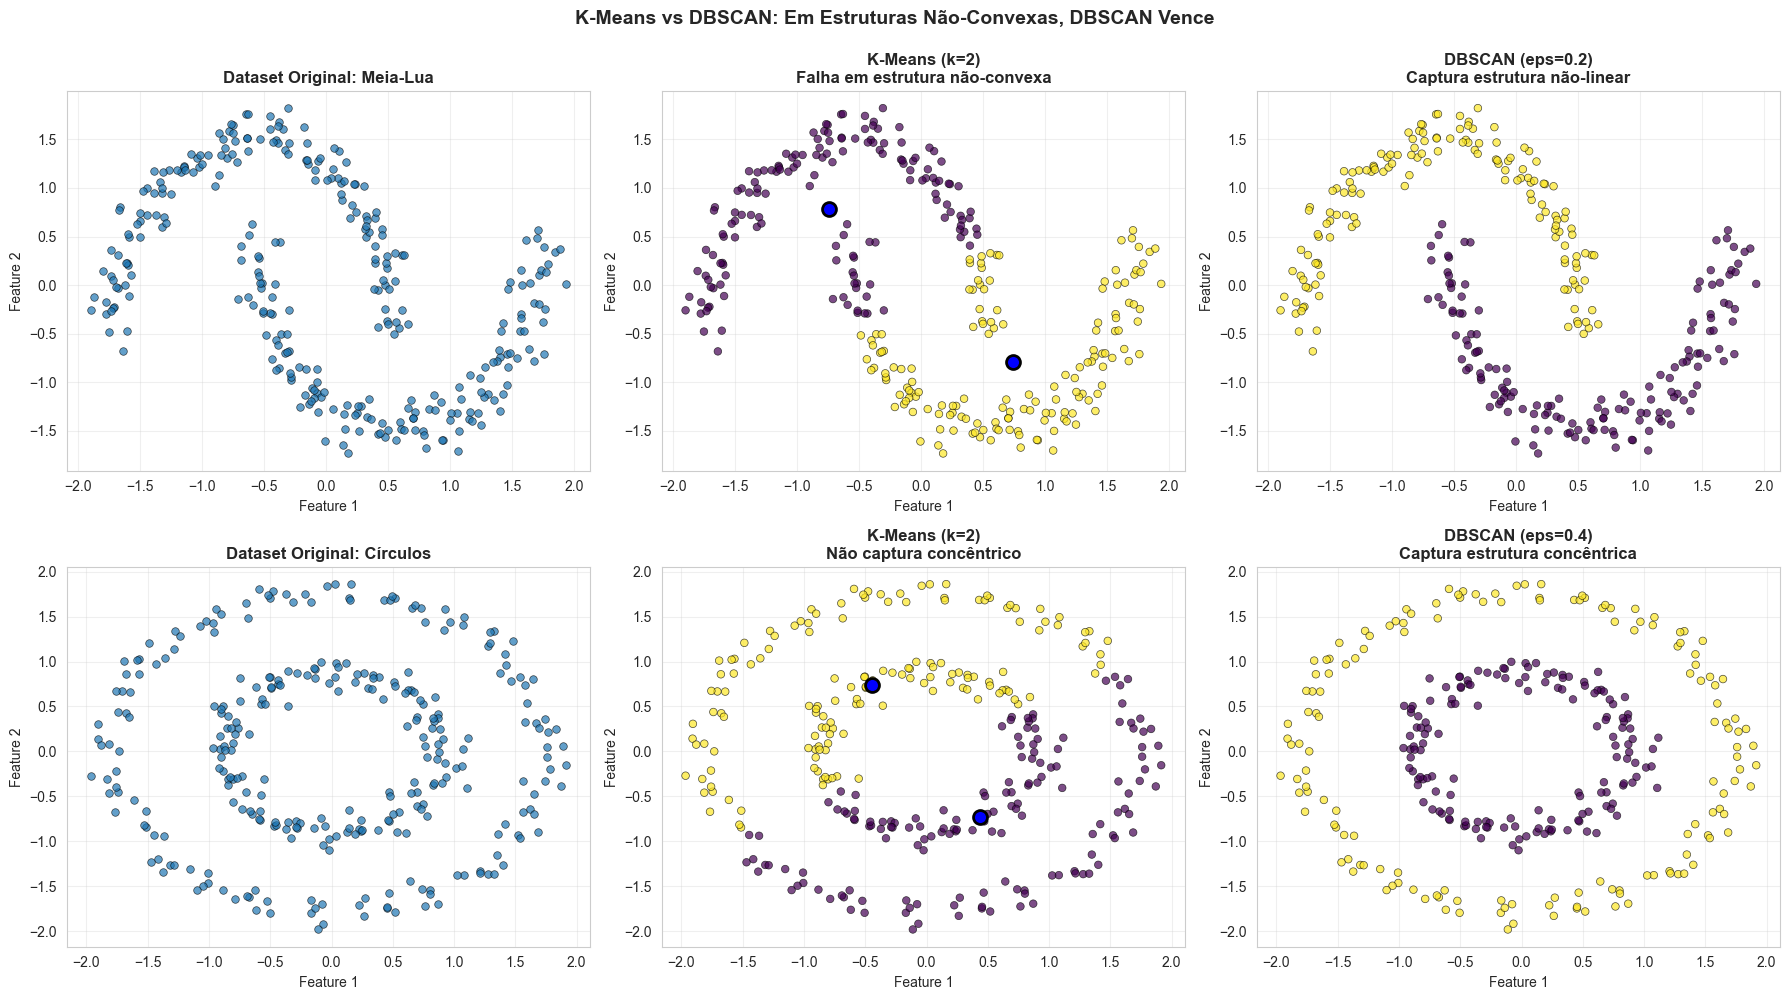

In [65]:
# ======= COMPARAÇÃO K-MEANS VS DBSCAN =======

# K-Means em meia-lua
kmeans_comparison = KMeans(n_clusters=2, n_init=10, random_state=42)
labels_kmeans_comp = kmeans_comparison.fit_predict(X_moons_norm)

# DBSCAN em meia-lua (já calculado)
dbscan_comparison = DBSCAN(eps=0.25, min_samples=5)
labels_dbscan_comp = dbscan_comparison.fit_predict(X_moons_norm)

# Visualizar lado-a-lado
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Linha 1: Dataset original e duas abordagens
axes[0, 0].scatter(X_moons_norm[:, 0], X_moons_norm[:, 1], s=30, alpha=0.7, edgecolors='k', linewidth=0.5)
axes[0, 0].set_title('Dataset Original: Meia-Lua', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Feature 1')
axes[0, 0].set_ylabel('Feature 2')
axes[0, 0].grid(True, alpha=0.3)

scatter_kmeans = axes[0, 1].scatter(X_moons_norm[:, 0], X_moons_norm[:, 1], 
                                    c=labels_kmeans_comp, cmap='viridis', s=30, alpha=0.7, edgecolors='k', linewidth=0.5)
axes[0, 1].scatter(kmeans_comparison.cluster_centers_[:, 0], kmeans_comparison.cluster_centers_[:, 1], 
                  marker='o', s=100, c='b', edgecolors='black', linewidth=2)
axes[0, 1].set_title('K-Means (k=2)\nFalha em estrutura não-convexa', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Feature 1')
axes[0, 1].set_ylabel('Feature 2')
axes[0, 1].grid(True, alpha=0.3)

scatter_dbscan = axes[0, 2].scatter(X_moons_norm[:, 0], X_moons_norm[:, 1], 
                                    c=labels_dbscan_comp, cmap='viridis', s=30, alpha=0.7, edgecolors='k', linewidth=0.5)
outliers_comp = labels_dbscan_comp == -1
axes[0, 2].set_title('DBSCAN (eps=0.2)\nCaptura estrutura não-linear', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Feature 1')
axes[0, 2].set_ylabel('Feature 2')
axes[0, 2].grid(True, alpha=0.3)

# Linha 2: Repetir para circles
X_circles_test = X_circles_norm

kmeans_circles_comp = KMeans(n_clusters=2, n_init=10, random_state=42)
labels_kmeans_circ = kmeans_circles_comp.fit_predict(X_circles_test)

dbscan_circles_comp = DBSCAN(eps=0.4, min_samples=5)
labels_dbscan_circ = dbscan_circles_comp.fit_predict(X_circles_test)

axes[1, 0].scatter(X_circles_test[:, 0], X_circles_test[:, 1], s=30, alpha=0.7, edgecolors='k', linewidth=0.5)
axes[1, 0].set_title('Dataset Original: Círculos', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Feature 1')
axes[1, 0].set_ylabel('Feature 2')
axes[1, 0].grid(True, alpha=0.3)

scatter_kmeans2 = axes[1, 1].scatter(X_circles_test[:, 0], X_circles_test[:, 1], 
                                     c=labels_kmeans_circ, cmap='viridis', s=30, alpha=0.7, edgecolors='k', linewidth=0.5)
axes[1, 1].scatter(kmeans_circles_comp.cluster_centers_[:, 0], kmeans_circles_comp.cluster_centers_[:, 1], 
                   marker='o', s=100, c='b', edgecolors='black', linewidth=2)
axes[1, 1].set_title('K-Means (k=2)\nNão captura concêntrico', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Feature 1')
axes[1, 1].set_ylabel('Feature 2')
axes[1, 1].grid(True, alpha=0.3)

scatter_dbscan2 = axes[1, 2].scatter(X_circles_test[:, 0], X_circles_test[:, 1], 
                                     c=labels_dbscan_circ, cmap='viridis', s=30, alpha=0.7, edgecolors='k', linewidth=0.5)
outliers_circ = labels_dbscan_circ == -1
axes[1, 2].set_title('DBSCAN (eps=0.4)\nCaptura estrutura concêntrica', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Feature 1')
axes[1, 2].set_ylabel('Feature 2')
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('K-Means vs DBSCAN: Em Estruturas Não-Convexas, DBSCAN Vence', 
             fontsize=14, y=0.995, fontweight='bold')
plt.tight_layout()
plt.show()


---

<a id='gmm'></a>
## 6. Gaussian Mixture Models (GMM)

<a id='gmm-intuicao'></a>
### 6.1 Definição e Intuição

**Gaussian Mixture Models (GMM)** oferece uma perspectiva probabilística sobre clustering. Ao invés de atribuir cada ponto rigidamente a um único cluster, GMM assume que os dados foram gerados a partir de uma mistura de $k$ **distribuições gaussianas (normais)** com diferentes médias e variâncias.

A intuição é elegante: imagine que você tem $k$ máquinas, cada uma gerando pontos a partir de uma distribuição normal diferente. Você observa todos os pontos misturados, mas não sabe qual máquina gerou cada um. O objetivo é **recuperar** as $k$ distribuições e, idealmente, atribuir probabilidades de que cada ponto veio de cada máquina.

Diferentemente de K-Means (atribuição: ponto pertence a cluster 0 ou 1) e DBSCAN (atribuição com outliers), GMM oferece **probabilidades**: cada ponto tem probabilidade $p_1, p_2, ..., p_k$ de pertencer a cada cluster, onde $p_1 + p_2 + ... + p_k = 1$.

**Vantagens do GMM**:
- Fornece probabilidades, não apenas atribuições
- Flexível: cada componente pode ter sua própria covariância
- Fundamentado em teoria probabilística (MLE - Maximum Likelihood Estimation)
- Oferece critérios de seleção de $k$ (AIC, BIC) bem-definidos

**Limitações**:
- Computacionalmente mais custoso (usa algoritmo EM iterativo)
- Assume dados gaussianos - falha se a suposição é muito violated
- Mais hiperparâmetros para ajustar



<a id='gmm-matematica'></a>
### 6.2 Formulação Matemática

Um GMM com $k$ componentes é caracterizado por:

- **Proporções de mistura**: $\pi_1, ..., \pi_k$ (probabilidade de cada componente), com $\sum_j \pi_j = 1$
- **Médias**: $\boldsymbol{\mu}_1, ..., \boldsymbol{\mu}_k$ (centro de cada gaussiana)
- **Covariâncias**: $\boldsymbol{\Sigma}_1, ..., \boldsymbol{\Sigma}_k$ (forma de cada gaussiana)

A densidade de probabilidade conjunta para um ponto $\mathbf{x}_i$ é:

$$p(\mathbf{x}_i) = \sum_{j=1}^{k} \pi_j \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)$$

onde $\mathcal{N}(\mathbf{x} | \boldsymbol{\mu}, \boldsymbol{\Sigma})$ é a probabilidade de $\mathbf{x}$ sob a gaussiana com média $\boldsymbol{\mu}$ e covariância $\boldsymbol{\Sigma}$:

$$\mathcal{N}(\mathbf{x} | \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{\sqrt{(2\pi)^d |\boldsymbol{\Sigma}|}} \exp\left( -\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T\boldsymbol{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu}) \right)$$

**Algoritmo EM (Expectation-Maximization)**:

O objetivo é encontrar parâmetros $\{\pi_j, \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j\}$ que maximizam a verossimilhança (likelihood) dos dados. Isso é feito iterativamente:

**Passo E (Expectation)**: Calcule a responsabilidade (probabilidade posterior) de cada componente para cada ponto:
$$\gamma_{ij} = \frac{\pi_j \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)}{\sum_{\ell=1}^{k} \pi_\ell \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}_\ell, \boldsymbol{\Sigma}_\ell)}$$

**Passo M (Maximization)**: Atualize os parâmetros usando as responsabilidades:
$$\pi_j = \frac{1}{m} \sum_{i=1}^{m} \gamma_{ij}$$
$$\boldsymbol{\mu}_j = \frac{\sum_{i=1}^{m} \gamma_{ij} \mathbf{x}_i}{\sum_{i=1}^{m} \gamma_{ij}}$$
$$\boldsymbol{\Sigma}_j = \frac{\sum_{i=1}^{m} \gamma_{ij} (\mathbf{x}_i - \boldsymbol{\mu}_j)(\mathbf{x}_i - \boldsymbol{\mu}_j)^T}{\sum_{i=1}^{m} \gamma_{ij}}$$

O algoritmo alternando E e M até convergência, maximizando a verossimilhança logarítmica do dataset.



<a id='gmm-implementacao'></a>
### 6.3 Implementação com Scikit-Learn


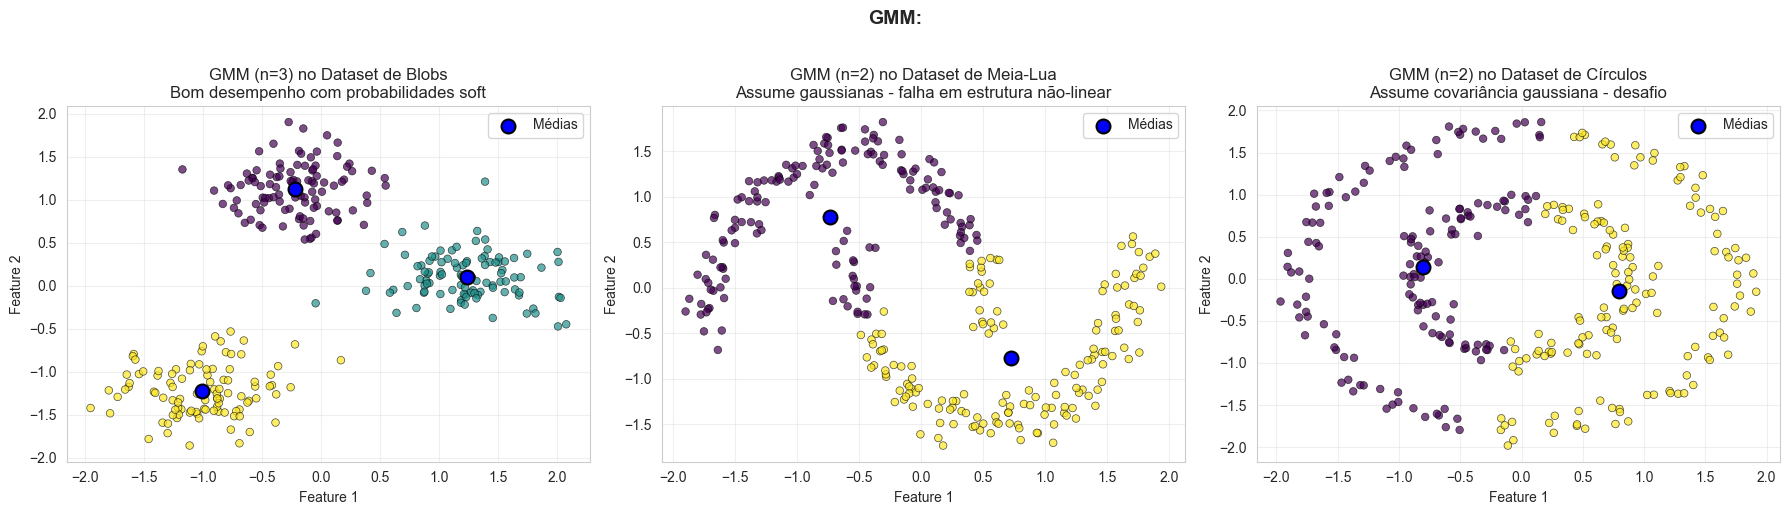

In [82]:
# ======= GAUSSIAN MIXTURE MODELS NOS DATASETS =======

# GMM nos três datasets
gmm_blobs = GaussianMixture(n_components=3, random_state=42)
labels_gmm_blobs = gmm_blobs.fit_predict(X_blobs_norm)
probas_gmm_blobs = gmm_blobs.predict_proba(X_blobs_norm)

gmm_moons = GaussianMixture(n_components=2, random_state=42)
labels_gmm_moons = gmm_moons.fit_predict(X_moons_norm)
probas_gmm_moons = gmm_moons.predict_proba(X_moons_norm)

gmm_circles = GaussianMixture(n_components=2, random_state=42)
labels_gmm_circles = gmm_circles.fit_predict(X_circles_norm)
probas_gmm_circles = gmm_circles.predict_proba(X_circles_norm)

# Visualizar
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Dataset 1: Blobs
scatter1 = axes[0].scatter(X_blobs_norm[:, 0], X_blobs_norm[:, 1], 
                           c=labels_gmm_blobs, cmap='viridis', s=30, alpha=0.7, edgecolors='k', linewidth=0.5)
# Plotar elipses das gaussianas (simplificado: apenas centros)
axes[0].scatter(gmm_blobs.means_[:, 0], gmm_blobs.means_[:, 1], 
               marker='o', s=100, c='b', edgecolors='black', linewidth=1.5, label='Médias')
axes[0].set_title('GMM (n=3) no Dataset de Blobs\nBom desempenho com probabilidades soft', fontsize=12)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Dataset 2: Meia-lua
scatter2 = axes[1].scatter(X_moons_norm[:, 0], X_moons_norm[:, 1], 
                           c=labels_gmm_moons, cmap='viridis', s=30, alpha=0.7, edgecolors='k', linewidth=0.5)
axes[1].scatter(gmm_moons.means_[:, 0], gmm_moons.means_[:, 1], 
               marker='o', s=100, c='b', edgecolors='black', linewidth=1.5, label='Médias')
axes[1].set_title('GMM (n=2) no Dataset de Meia-Lua\nAssume gaussianas - falha em estrutura não-linear', fontsize=12)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Dataset 3: Círculos
scatter3 = axes[2].scatter(X_circles_norm[:, 0], X_circles_norm[:, 1], 
                           c=labels_gmm_circles, cmap='viridis', s=30, alpha=0.7, edgecolors='k', linewidth=0.5)
axes[2].scatter(gmm_circles.means_[:, 0], gmm_circles.means_[:, 1], 
               marker='o', s=100, c='b', edgecolors='black', linewidth=1.5, label='Médias')
axes[2].set_title('GMM (n=2) no Dataset de Círculos\nAssume covariância gaussiana - desafio', fontsize=12)
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('GMM:', 
             fontsize=14, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()



<a id='gmm-analise'></a>
### 6.4 Análise de Clusters e Critérios de Informação

**Probabilidades Soft vs Hard**: Uma vantagem única do GMM é que oferece probabilidades. Ao invés de atribuição ("este ponto pertence a cluster 2"), você obtém ("este ponto tem 85% de probabilidade de estar em cluster 2 e 15% em cluster 1"). Isso é especialmente útil quando há incerteza.

**Critérios de Seleção de k**: Como escolher o número de componentes em GMM? Ao contrário de K-Means (que usa elbow method) ou DBSCAN (que não tem $k$), GMM oferece critérios estatísticos bem fundamentados que já vimos:

- **AIC (Akaike Information Criterion)**: $\text{AIC} = 2p - 2\ln(\hat{L})$, onde $p$ é número de parâmetros e $\hat{L}$ é likelihood máxima
- **BIC (Bayesian Information Criterion)**: $\text{BIC} = p\ln(m) - 2\ln(\hat{L})$

Ambos penalizam modelos com muitos parâmetros (evitam overfitting). **Menores valores são melhores**. O BIC tende a preferir modelos mais simples que o AIC.


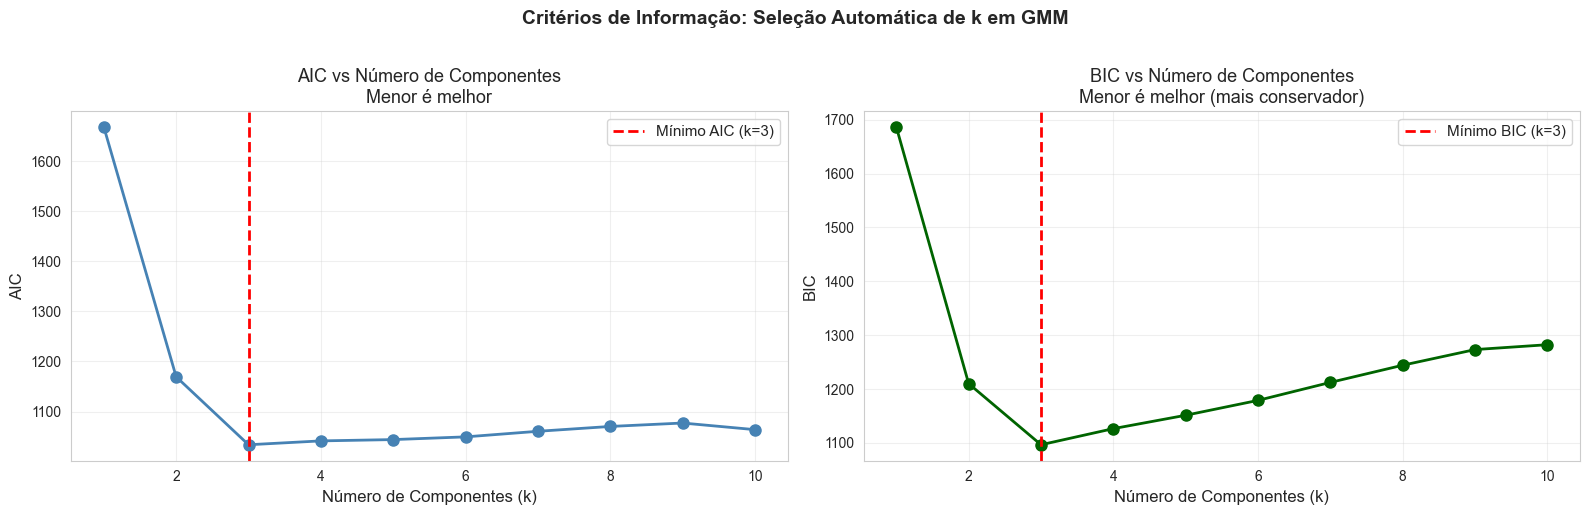

In [74]:
# ======= ESCOLHA ÓTIMA DE k COM AIC E BIC =======

# Calcular AIC e BIC para diferentes números de componentes
n_components_range = range(1, 11)
aics = []
bics = []

for n_comp in n_components_range:
    gmm = GaussianMixture(n_components=n_comp, random_state=42)
    gmm.fit(X_blobs_norm)
    aics.append(gmm.aic(X_blobs_norm))
    bics.append(gmm.bic(X_blobs_norm))

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# AIC
axes[0].plot(n_components_range, aics, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].axvline(x=np.argmin(aics)+1, color='red', linestyle='--', linewidth=2, 
               label=f'Mínimo AIC (k={np.argmin(aics)+1})')
axes[0].set_xlabel('Número de Componentes (k)', fontsize=12)
axes[0].set_ylabel('AIC', fontsize=12)
axes[0].set_title('AIC vs Número de Componentes\nMenor é melhor', fontsize=13)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# BIC
axes[1].plot(n_components_range, bics, marker='o', linewidth=2, markersize=8, color='darkgreen')
axes[1].axvline(x=np.argmin(bics)+1, color='red', linestyle='--', linewidth=2, 
               label=f'Mínimo BIC (k={np.argmin(bics)+1})')
axes[1].set_xlabel('Número de Componentes (k)', fontsize=12)
axes[1].set_ylabel('BIC', fontsize=12)
axes[1].set_title('BIC vs Número de Componentes\nMenor é melhor (mais conservador)', fontsize=13)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Critérios de Informação: Seleção Automática de k em GMM', fontsize=14, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

<a id='outros-metodos'></a>
## 7. Outros Métodos de Clustering

Além dos três métodos principais que exploramos em profundidade (K-Means, DBSCAN e GMM), existem diversos outros algoritmos especializados para cenários específicos. Cada um oferece perspectivas únicas sobre como agrupar dados.

### Hierarchical Clustering (Clustering Hierárquico)

Clustering Hierárquico constrói uma árvore de clusters (dendrograma) de forma ascendente (aglomerativa) ou descendente (divisiva). Ao invés de particionar dados uma única vez, oferece uma hierarquia completa de possíveis agrupamentos em diferentes níveis de granularidade. A ideia é simples: comece com cada ponto como um cluster próprio e vá mesclando os clusters mais próximos iterativamente (abordagem aglomerativa), ou comece com todos os pontos em um único cluster e vá dividindo (abordagem divisiva). Ao final, você pode "cortar" o dendrograma em qualquer altura para obter o número desejado de clusters.

A grande vantagem é que você obtém uma perspectiva completa da estrutura hierárquica dos dados - útil especialmente em taxonomia biológica, análise de redes sociais e estudos filogenéticos. A principal limitação é o custo computacional: requer $O(m^2)$ memória para armazenar matriz de distâncias, tornando-o impraticável para datasets muito grandes. Além disso, é sensível à métrica de ligação escolhida (single-linkage vs complete-linkage vs average-linkage), que pode produzir resultados drasticamente diferentes.

**Extra**: [`sklearn.cluster.AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

---

### Spectral Clustering

Spectral Clustering usa autovalores e autovetores de matrizes de afinidade (similaridade) para reduzir dimensionalidade antes de aplicar K-Means. É fundamentado em teoria de grafos: os dados são tratados como um grafo onde cada ponto é um nó e arestas representam similaridade. A ideia é encontrar um corte no grafo que minimize conexões entre clusters e maximize conexões dentro de clusters. Na prática, isso é feito calculando autovetores da matriz Laplaciana do grafo e usando-os como features para K-Means.

É especialmente bom em clusters não-convexos com estruturas de rede complexas - funcionalmente similar a LLE (Local Linear Embedding) em redução de dimensionalidade, mas aplicado a clustering. A vantagem é que captura estruturas não-lineares arbitrárias que K-Means falharia. A desvantagem é que requer construção de uma matriz de afinidade completa ($m \times m$), tornando-o custoso em altas dimensões. Além disso, ainda requer que você especifique $k$ (número de clusters) como entrada.

**Extra**: [`sklearn.cluster.SpectralClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)

---

### Affinity Propagation

Affinity Propagation usa um mecanismo de "troca de mensagens" entre pontos de dados para descobrir clusters naturalmente, sem requerer $k$ de antemão (similar ao DBSCAN nesse aspecto). A ideia é que cada ponto envia mensagens de "responsabilidade" e "disponibilidade" para outros pontos: responsabilidade indica quanto um ponto $i$ prefere ponto $k$ como seu exemplar (representante de cluster); disponibilidade indica quanto ponto $k$ está disponível para ser exemplar de $i$. Essas mensagens são trocadas iterativamente até convergência, quando emergem naturalmente os exemplares finais e suas associações.

A vantagem é dupla: não requer $k$ pré-especificado e usa informação global de todo o dataset (ao contrário de DBSCAN que usa apenas vizinhança local). A limitação principal é o custo computacional - precisa de uma matriz de similaridade $m \times m$ completa - e sensibilidade ao parâmetro de "preferência" que controla quantos clusters serão formados.

**Extra**: [`sklearn.cluster.AffinityPropagation`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html)

---

### Mean Shift

Mean Shift é um algoritmo baseado em estimação de densidade que iterativamente desloca pontos em direção à região de maior densidade local. Imagine uma paisagem de densidade de probabilidade onde picos representam clusters: Mean Shift realiza gradient ascent (subida do gradiente) no histograma suavizado dos dados, movendo cada ponto em direção ao centroide de sua vizinhança local. Eventualmente, pontos convergem para os mesmos picos de densidade e formam clusters naturalmente.

A grande vantagem é que encontra clusters automaticamente baseado puramente em densidade, sem requerer $k$. É especialmente bom para distribuições multimodais (múltiplos picos). A desvantagem é o custo computacional em altas dimensões e sensibilidade ao parâmetro de bandwidth do kernel (que controla o tamanho da janela de densidade). Escolher bandwidth inadequado pode resultar em sub-segmentação ou super-segmentação.

**Extra**: [`sklearn.cluster.MeanShift`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html)

---

### HDBSCAN

HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) é uma extensão sofisticada de DBSCAN que combina clustering hierárquico com densidade. Ao invés de usar um único valor fixo de $\epsilon$ (raio), HDBSCAN constrói uma hierarquia completa de clusters em diferentes escalas de densidade. Depois, usa uma abordagem principiada baseada em "estabilidade" de clusters para escolher automaticamente a melhor resolução. Além disso, oferece probabilidades de pertencimento (soft assignment) ao invés de atribuições rígidas.

Combina as vantagens de clustering hierárquico (perspectiva multi-escala) com DBSCAN (detecção de outliers, clusters baseados em densidade). É robusto à escolha de parâmetros - essencialmente só requer `min_cluster_size`. A principal limitação é que não está incluído no scikit-learn padrão - requer instalação do pacote separado `hdbscan`. Além disso, é ligeiramente mais complexo de configurar e interpretar que DBSCAN vanilla.

**Extra**: [`sklearn.cluster.HDBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html)

---

<-- [**Anterior: Redução de Dimensionalidade**](02_dimensionality_reduction.ipynb)